# Creating Auto-Encoder

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import tensorflow                         as tf

import romnet                             as rmnt

In [2]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'

OutputDir          = WORKSPACE_PATH+'/ROMNet/Data/PSR_100Cases/'

PathToRunFld       = WORKSPACE_PATH + '/ROMNet/PSR_100Cases/AutoEncoder/Deterministic/Run_8/'

NVarsRed           = 3

ValidPerc          = 20.

FixedMinVal        = 1.e-10

In [3]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH, ROMNetFldr)


InputData.InputFilePath = PathToRunFld+'/ROMNet_Input.py'
InputData.TrainIntFlg   = 0
InputData.PathToRunFld  = PathToRunFld


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/PSR_100Cases/AutoEncoder/Deterministic/Run_8/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


In [4]:
SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

Net   = getattr(rmnt.nn, SurrogateType)

model = rmnt.model.Model_Deterministic(InputData)

model.build(InputData, None, Net)#, loadfile_no='000004')

NN    = model.net


[ROMNet]:   Initializing the ML Model

[ROMNet]:   Building the ML Model

[ROMNet]:   Loading ML Model Parameters from File:  /Users/sventuri/WORKSPACE//ROMNet/PSR_100Cases/AutoEncoder/Deterministic/Run_8//Training/Params//000330.h5
'load_params' took 0.017386 s


[ROMNet]:   Saving ML Model Parameters to File:  /Users/sventuri/WORKSPACE//ROMNet/PSR_100Cases/AutoEncoder/Deterministic/Run_8//Model/Params/Initial.h5
'save_params' took 0.018098 s

'build' took 0.163596 s



In [5]:
Data      = pd.read_csv(OutputDir+'/Orig/train/ext/CleanVars.csv', header=None)
orig_vars = list(Data.to_numpy()[0,:])

red_vars  = ['i'+str(i+1) for i in range(NVarsRed)]


Data      = pd.read_csv(OutputDir+'/Orig/train/ext/Output.csv')
orig_data = Data[orig_vars]

In [6]:
HH_min   = orig_data['HH'].min()
HH_range = orig_data['HH'].max() - orig_data['HH'].min()

mean     = orig_data.mean()
std      = orig_data.std()

In [7]:
def pre_fun_log(orig_data):
    
    mod_data       = orig_data.copy()
    mod_data['HH'] = (orig_data['HH'] - HH_min) / HH_range

    for var in list(orig_data.columns)[1:]:
        mod_data[var] = np.log10(orig_data[var]) 
    
    return mod_data


def pre_fun_pareto(orig_data):
    
    mod_data       = orig_data.copy()
    for i, var in enumerate(list(orig_data.columns)):
        mod_data[var] = (mod_data[var] - mean[i]) / np.sqrt(std[i])
    
    return mod_data

In [8]:
def post_fun_log(orig_data):
    
    mod_data       = orig_data.copy()
    mod_data['HH'] = orig_data['HH'] * HH_range + HH_min

    for var in list(orig_data.columns)[1:]:
        mod_data[var] = 10**(orig_data[var]) 
    
    return mod_data


def post_fun_pareto(orig_data):
    
    mod_data       = orig_data.copy()
    for i, var in enumerate(list(orig_data.columns)):
        mod_data[var] = mod_data[var] * np.sqrt(std[i]) + mean[i] 
    
    return mod_data

In [9]:
# pre_fun  = pre_fun_log
# post_fun = post_fun_log

pre_fun  = pre_fun_pareto
post_fun = post_fun_pareto

In [10]:
mod_data = pre_fun(orig_data)

In [11]:
pred_data    = model.predict(mod_data)
pred_data    = pd.DataFrame(pred_data, columns=mod_data.columns) 
#pred_data    = post_fun(pred_data)

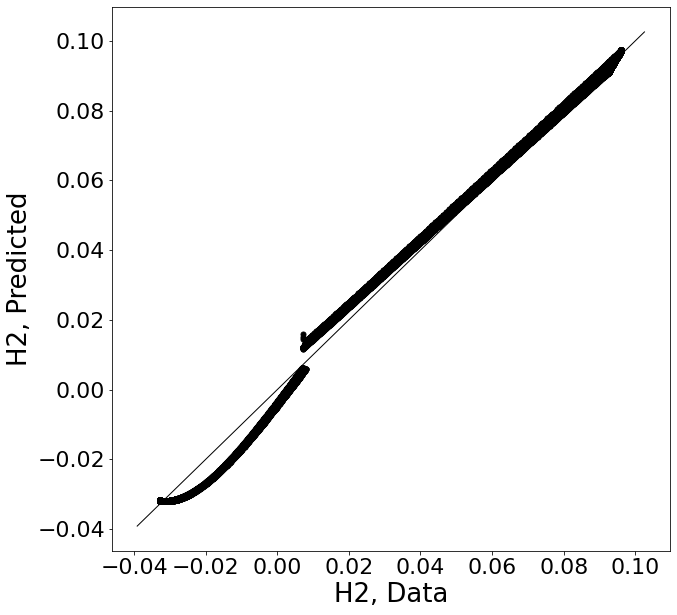

In [12]:
var = 'H2'

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(mod_data[var], pred_data[var], 'ko', markersize=5, label='Train')
ax.set_xlabel(var+', Data')
ax.set_ylabel(var+', Predicted')
#ax.legend()
xlim = ax.get_xlim()
ylim = ax.get_xlim()
plt.plot(xlim,ylim,'k-',linewidth=1)

In [13]:
FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

In [14]:
pca_data      = ((orig_data - C[:,0]) / D[:,0]).dot(A.T)
orig_data_pca = pca_data.dot(A) * D[:,0] + C[:,0]
orig_data_pca.columns = orig_data.columns

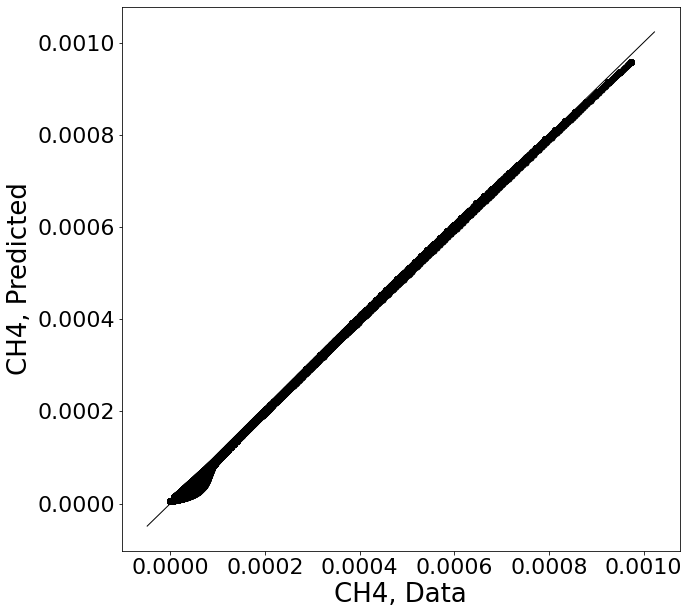

In [15]:
var = 'CH4'

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(orig_data[var], orig_data_pca[var], 'ko', markersize=5, label='Train')
ax.set_xlabel(var+', Data')
ax.set_ylabel(var+', Predicted')
#ax.legend()
xlim = ax.get_xlim()
ylim = ax.get_xlim()
plt.plot(xlim,ylim,'k-',linewidth=1)